In [3]:
import os
import warnings
import matplotlib
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import models.reader_pointer_extended as reader_EN
import models.reader_pointer_original as reader_PMN

from models.config import SmallConfig, TestConfig, BestConfig
from models.extendedNetwork import EN, ENInput
from models.pointerMixture import PMN, PMNInput
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [21]:
def create_confusion_matrix(valid_data, checkpoint, eval_config, class_indices=None, is_extended=True):
    if is_extended:
        conf = np.zeros(shape=(4,4))
        hogID = eval_config.vocab_size[1] - 2
        unkID = eval_config.vocab_size[1] - 3
    else:
        conf = np.zeros(shape=(3,3))
        unkID = eval_config.vocab_size[1] - 2
    
    with tf.Graph().as_default():
        initializer = tf.random_uniform_initializer(-eval_config.init_scale, eval_config.init_scale)
        
        if is_extended:
            with tf.name_scope("Valid"):
                valid_input = ENInput(config=eval_config, data=valid_data, name="ValidInput", FLAGS=FLAGS)
                with tf.variable_scope("Model", reuse=False, initializer=initializer):
                    mvalid = EN(is_training=False, config=eval_config, input_=valid_input, FLAGS=FLAGS)
        else:
            with tf.name_scope("Valid"):
                valid_input = PMNInput(config=eval_config, data=valid_data, name="ValidInput", FLAGS=FLAGS)
                with tf.variable_scope("Model", reuse=False, initializer=initializer):
                    mvalid = PMN(is_training=False, config=eval_config, input_=valid_input, FLAGS=FLAGS)

            
        print('total trainable variables', len(tf.trainable_variables()), '\n\n')

        saver = tf.train.Saver(tf.trainable_variables())
        sv = tf.train.Supervisor(logdir=None, summary_op=None)

        with sv.managed_session() as session:
            saver.restore(session, checkpoint)

            state = session.run(mvalid.initial_state)
            eof_indicator = np.ones(mvalid.input.batch_size, dtype=bool)
            memory = np.zeros([mvalid.input.batch_size, mvalid.input.num_steps, mvalid.size])

            for step in tqdm(range(50)):
                feed_dict = {}
                sub_cond = np.expand_dims(eof_indicator, axis=1)
                condition = np.repeat(sub_cond, mvalid.size, axis=1)
                zero_state = session.run(mvalid.initial_state)

                for i, (c, h) in enumerate(mvalid.initial_state):
                    assert condition.shape == state[i].c.shape
                    feed_dict[c] = np.where(condition, zero_state[i][0], state[i].c)
                    feed_dict[h] = np.where(condition, zero_state[i][1], state[i].h)

                feed_dict[mvalid.memory] = memory
                probs, labels = session.run([mvalid.probs, mvalid.labels], feed_dict)
                prediction = np.argmax(probs, 1)
                
                if is_extended:
                    new_labels = [0 if label==hogID else 1 if label == unkID else 2 for label in labels]
                    new_prediction = [0 if pred == hogID else 1 if pred == unkID else 2 if pred == label else 3 
                          for pred, label in zip(prediction, labels)]
                else:
                    new_labels = [1 if label == unkID else 2 for label in labels]
                    new_prediction = [1 if pred == unkID else 2 if pred == label else 3 
                          for pred, label in zip(prediction, labels)]
                    
                # add arrays to get true positives and true negatives
                conf += confusion_matrix(new_labels, new_prediction)
    return conf

In [5]:
def plot_confusion_matrix(conf, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    matplotlib.rcParams.update({'font.size': 13})
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = conf
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
tf.logging.set_verbosity(tf.logging.FATAL)

N_filename_EN = 'pickle_data/PY_non_terminal_dev.pickle'
T_filename_EN = 'pickle_data/PY_terminal_1k_extended_dev.pickle'

N_filename_PMN = 'pickle_data/PY_non_terminal.pickle'
T_filename_PMN = 'pickle_data/PY_terminal_1k_whole.pickle'


flags = tf.app.flags
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string("model",
                    "best",
                    "A type of model. Possible options are: small, medium, best.")


flags.DEFINE_bool("use_fp16", False,
                  "Train using 16-bit floats instead of 32bit floats")
FLAGS = flags.FLAGS
logging = tf.logging

In [7]:
def get_config():
    if FLAGS.model == "small":
        return SmallConfig()
    elif FLAGS.model == "test":
        return TestConfig()
    elif FLAGS.model == "best":
        return BestConfig()
    else:
        raise ValueError("Invalid model: %s", FLAGS.model)

## Evaluating the Extended Network

In [22]:
train_dataN, valid_dataN, vocab_sizeN, train_dataT, valid_dataT, vocab_sizeT, attn_size = reader_EN.input_data(
    N_filename_EN, T_filename_EN)

train_data_EN = (train_dataN, train_dataT)
valid_data_EN = (valid_dataN, valid_dataT)
vocab_size_EN = (vocab_sizeN + 1, vocab_sizeT + 3)  # N is [w, eof], T is [w, unk_id, hog_id, eof]
eval_config = get_config()
eval_config.hogWeight = 1.0
eval_config.vocab_size = vocab_size_EN
eval_config.num_layers = 2

reading data from  pickle_data/PY_non_terminal_dev.pickle
the vocab_sizeN is 311 (not including the eof)
the number of training data is 90000
the number of test data is 10000

reading data from  pickle_data/PY_terminal_1k_extended_dev.pickle
the vocab_sizeT is 1000 (not including the unk and eof)
the attn_size is 50
the number of training data is 90000
the number of test data is 10000
Finish reading data and take 9.01



In [ ]:
cm_boosted = create_confusion_matrix(valid_data_EN, 'models/logs/boosted_hog/PMN--4', eval_config)
cm_less = create_confusion_matrix(valid_data_EN, 'models/logs/less_hog/PMN--2', eval_config)

In [ ]:
cm_2_layer_20 = create_confusion_matrix(valid_data_EN, 'models/logs/extended_dev_20_drop_2_layer/PMN--7', eval_config)

In [25]:
one_layer_config = eval_config
one_layer_config.num_layers = 1
cm_1_layer_wo_drop = create_confusion_matrix(valid_data_EN, 'models/logs/extended_dev_without_drop/PMN--7',
                                             one_layer_config)

Pading two long lines and take 0.26s
Finish preparing input producer and takes 1.90s
Each produce data takes time 0.11

total trainable variables 14 




100%|██████████| 50/50 [06:43<00:00,  7.95s/it]


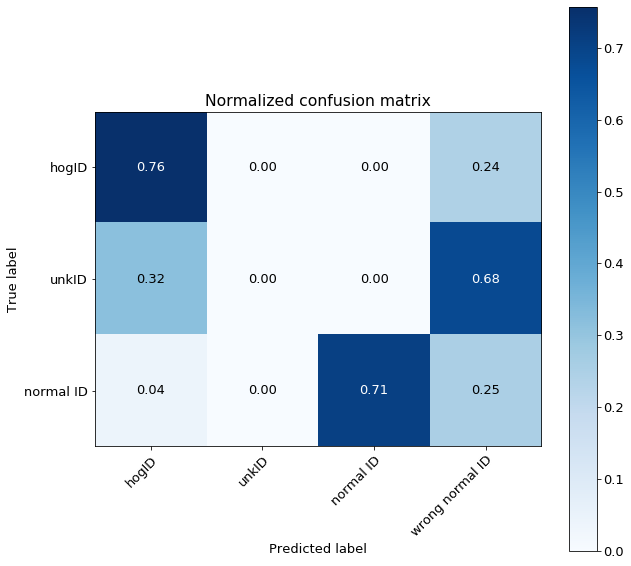

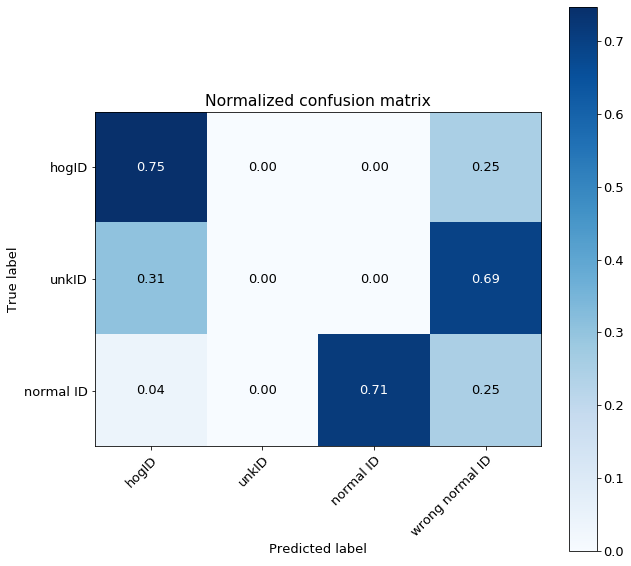

In [29]:
plot_confusion_matrix(cm_less.astype(int)[:3], ["hogID","unkID","normal ID","wrong normal ID"], normalize=True)
plot_confusion_matrix(cm_boosted.astype(int)[:3], ["hogID","unkID","normal ID","wrong normal ID"], normalize=True)

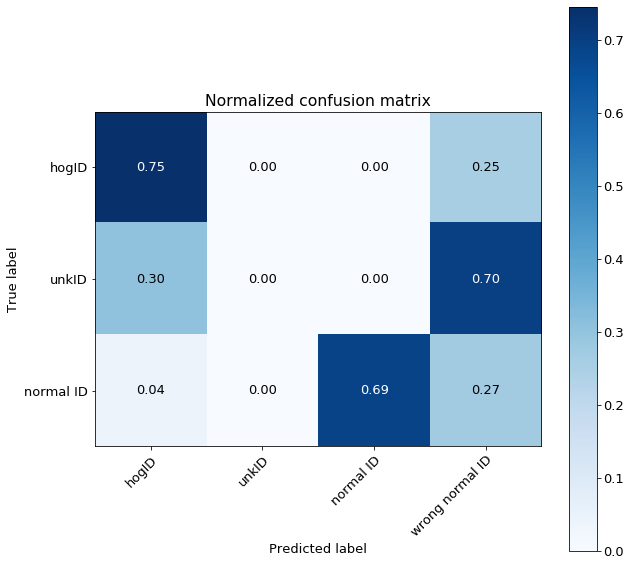

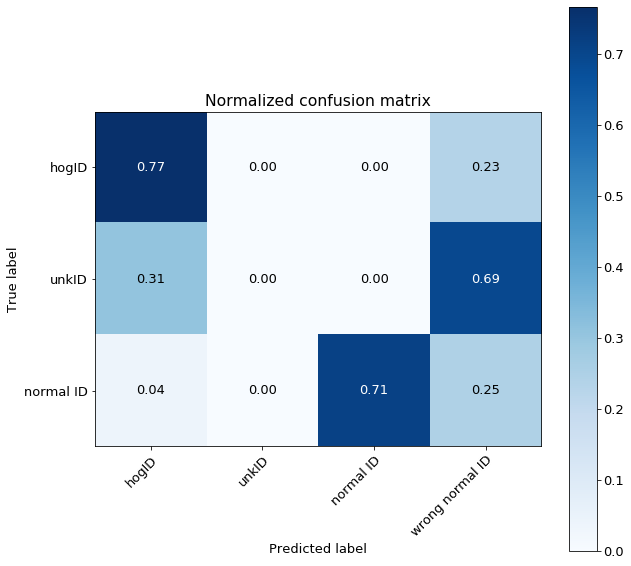

In [34]:
plot_confusion_matrix(cm_1_layer_wo_drop.astype(int)[:3], ["hogID","unkID","normal ID","wrong normal ID"], normalize=True)
plot_confusion_matrix(cm_2_layer_20.astype(int)[:3], ["hogID","unkID","normal ID","wrong normal ID"], normalize=True)

In [33]:
precision_baseline_hog = 4378/(4378+11352)
precision_2layer_hog = 4499/(4499+10560)

precision_2layer_normal = 195130/(195130+67608+10560)
precision_baseline_normal = 188535/(73411+188535+11352)

print(precision_baseline)
print(precision_2layer)

print(precision_baseline_normal)
print(precision_2layer_normal)

0.2783216783216783
0.2987582176771366
0.6898513710308893
0.7139825392062876


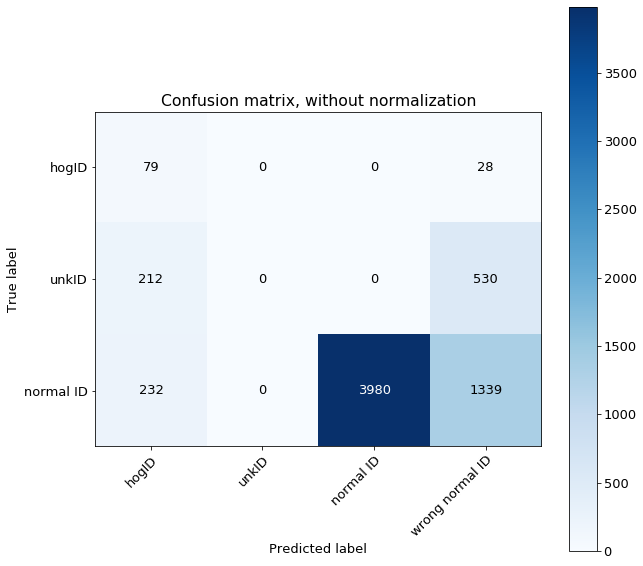

In [19]:
plot_confusion_matrix(cm.astype(int)[:3], ["hogID","unkID","normal ID","wrong normal ID"], normalize=False)


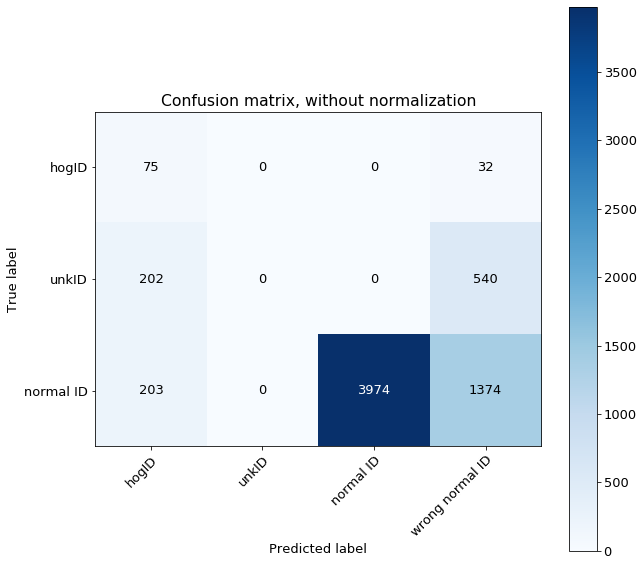

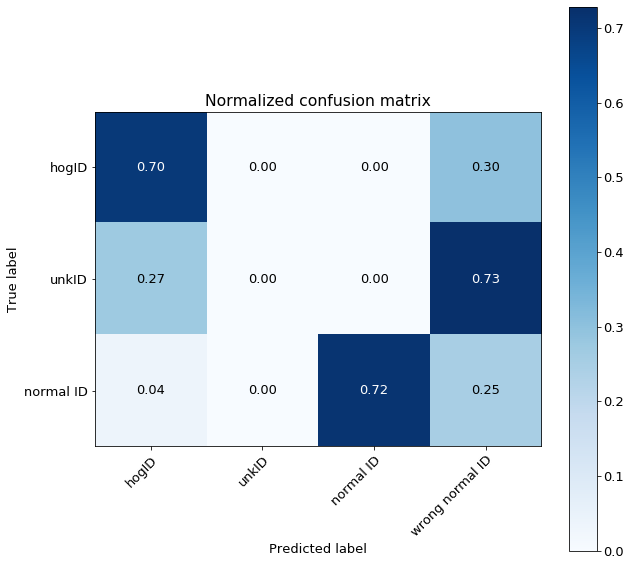

In [10]:
plot_confusion_matrix(cm.astype(int)[:3], ["hogID","unkID","normal ID","wrong normal ID"])
plot_confusion_matrix(cm.astype(int)[:3], ["hogID","unkID","normal ID","wrong normal ID"], normalize=True)
plt.show()

In [12]:
train_dataN, valid_dataN, vocab_sizeN, train_dataT, valid_dataT, vocab_sizeT, attn_size = reader_PMN.input_data(
    N_filename_PMN, T_filename_PMN)

train_data_PMN = (train_dataN, train_dataT)
valid_data_PMN = (valid_dataN, valid_dataT)
vocab_size_PMN = (vocab_sizeN + 1, vocab_sizeT + 2)  # N is [w, eof], T is [w, unk_id, eof]
eval_config = get_config()
eval_config.vocab_size = vocab_size_PMN
eval_config.num_layers = 1

cm = create_confusion_matrix(valid_data_PMN, 'models/logs/vanilla_pmn_train_test/PMN--6',
                             eval_config, is_extended=False)

reading data from  pickle_data/PY_non_terminal.pickle
the vocab_sizeN is 330 (not including the eof)
the number of training data is 100000
the number of test data is 50000

reading data from  pickle_data/PY_terminal_1k_whole.pickle
the vocab_sizeT is 1000 (not including the unk and eof)
the attn_size is 50
the number of training data is 100000
the number of test data is 50000
Finish reading data and take 14.46

Pading two long lines and take 0.78s
Finish preparing input producer and takes 8.42s
Each produce data takes time 0.04

total trainable variables 14 




100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


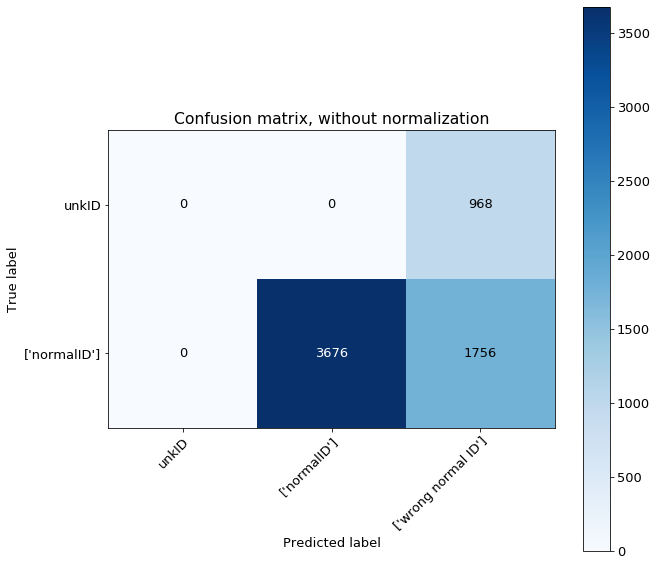

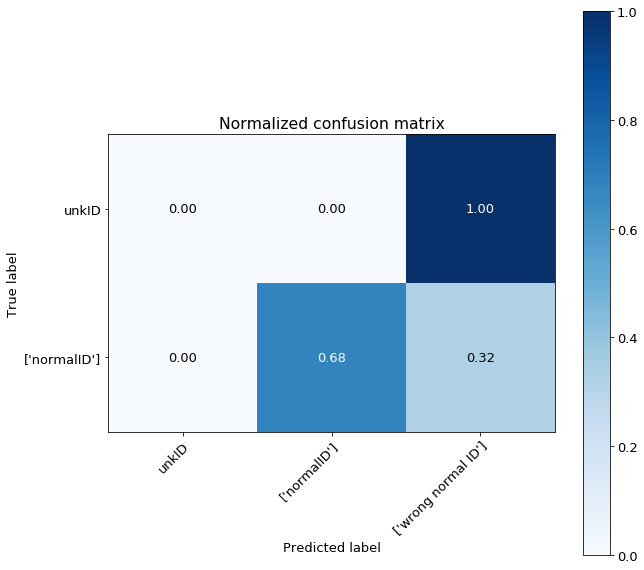

In [13]:
plot_confusion_matrix(cm[:2].astype(int), ["unkID", ["normalID"], ["wrong normal ID"]])
plot_confusion_matrix(cm[:2].astype(int), ["unkID", ["normalID"], ["wrong normal ID"]], normalize=True)
plt.show()